In [72]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

# データ読み込み

In [73]:
sales_history_df = pd.read_csv('./inputs/sales_history.csv')
category_names_df = pd.read_csv('./inputs/category_names.csv')
item_categories_df = pd.read_csv('./inputs/item_categories.csv')
test_x = pd.read_csv('./inputs/test.csv')

In [74]:
train_df = sales_history_df.copy()
test_df = test_x.copy()

In [75]:
train_df.columns

Index(['日付', '店舗ID', '商品ID', '商品価格', '売上個数'], dtype='object')

In [76]:
test_df.columns

Index(['index', '商品ID', '店舗ID'], dtype='object')

# 可視化

## 長さ

In [77]:
print('len(train)=', len(train_df))
print('len(test)', len(test_df))
print(len(test_df)/len(train_df))

len(train)= 1119570
len(test) 3060
0.002733192207722608


## ベン図

Text(0.5, 1.0, '店舗ID')

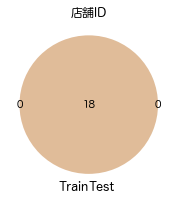

In [68]:
c = '店舗ID'

fig, ax = plt.subplots(figsize=(5, 3))
venn2(
    subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
    set_labels=('Train', 'Test'),
    ax=ax
)
ax.set_title(c)

Text(0.5, 1.0, '商品ID')

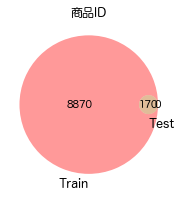

In [69]:
c = '商品ID'

fig, ax = plt.subplots(figsize=(5, 3))
venn2(
    subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
    set_labels=('Train', 'Test'),
    ax=ax
)
ax.set_title(c)

In [70]:
train_df = sales_history_df
input_df = item_categories_df.reset_index()

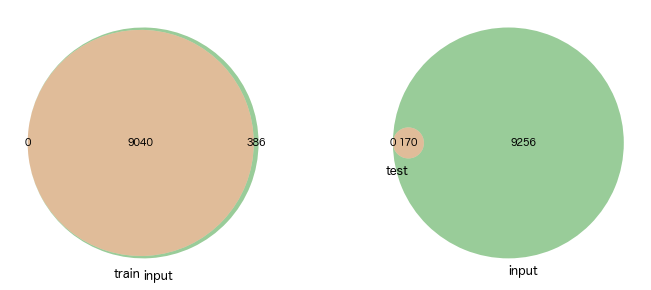

In [71]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=2)

v = venn2(subsets=(
    set(train_df['商品ID']), set(input_df['商品ID'])
), set_labels=('train', 'input'), ax=axes[0])

v = venn2(subsets=(
    set(test_df['商品ID']), set(input_df['商品ID'])
), set_labels=('test', 'input'), ax=axes[1])

## 欠損値

In [49]:
train_df.isnull().sum()

日付      0
店舗ID    0
商品ID    0
商品価格    0
売上個数    0
dtype: int64

In [50]:
test_df.isnull().sum()

index    0
商品ID     0
店舗ID     0
dtype: int64

## 相関係数

<AxesSubplot:>

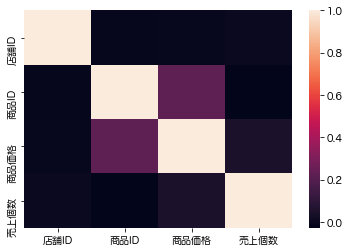

In [51]:
#相関係数のヒートマップ
corr_tr = train_df.corr()
corr_tr = pd.DataFrame(corr_tr)
sns.heatmap(corr_tr)

In [39]:
train_df.describe()

,店舗ID,商品ID,商品価格,売上個数
count,1.119570e+06,1.119570e+06,1.119570e+06,1.119570e+06
mean,7.975602e+00,1.458147e+06,1.049425e+03,1.127995e+00
std,5.015283e+00,5.695805e+05,1.257710e+03,7.890103e-01
min,0.000000e+00,1.000001e+06,0.000000e+00,-4.000000e+00
25%,4.000000e+00,1.100021e+06,3.400000e+02,1.000000e+00
50%,7.000000e+00,1.201152e+06,6.800000e+02,1.000000e+00
75%,1.300000e+01,1.600003e+06,1.270000e+03,1.000000e+00
max,1.700000e+01,3.500073e+06,5.235700e+05,1.510000e+02


In [41]:
train_df[train_df.売上個数 == 0]

,日付,店舗ID,商品ID,商品価格,売上個数


売れたもののみのデータしかない

売れなかったものも予測するなら0を追加する必要あり